In [1]:
import torch
# import data_s2s
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
import pdb

os.environ["CUDA_VISIBLE_DEVICES"]="5"
snapshot_scratch = "/shared/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2022-07-27_18-08-35/snapshot_0.pt"
r3m_scratch = load_r3m('resnet50', snapshot_scratch).to('cuda:0')
r3m_scratch.eval()
None

/home/amberxie/miniconda3/envs/sr3m_base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amberxie/miniconda3/envs/sr3m_base/lib/python3.9/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

In [2]:
def show_images(batch: torch.Tensor, size=None):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    images = Image.fromarray(reshaped.numpy())
    if size is not None:
        images = images.resize(size, Image.NEAREST)
    display(images)

def show_images_rlbench(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)
    
def show_images_ego4d(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)

/shared/ademi_adeniji/ego4d/videosresize224/1bec800a-c3cf-431f-bf0a-7632ad53bcb7
66289
66341
52


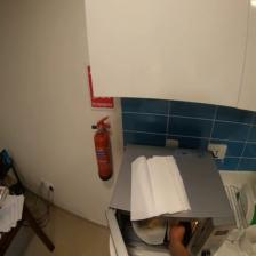

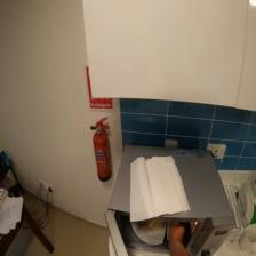

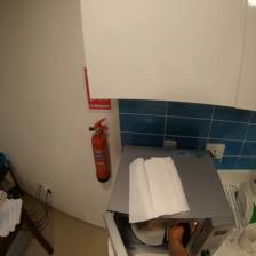

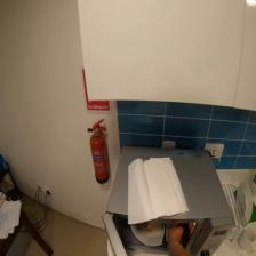

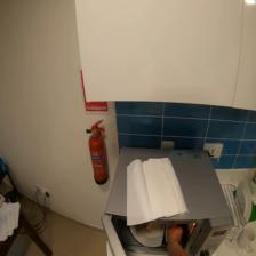

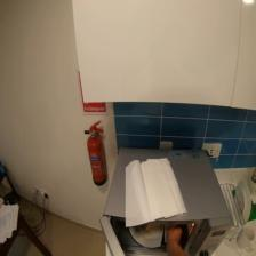

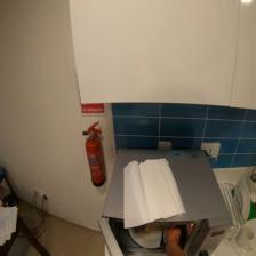

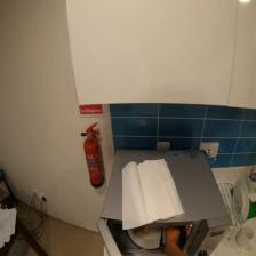

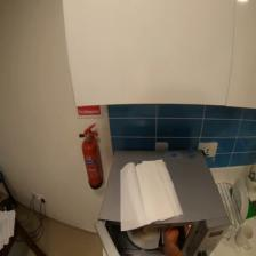

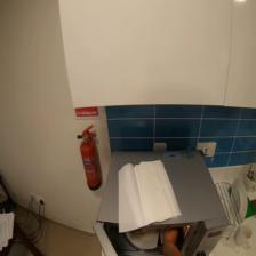

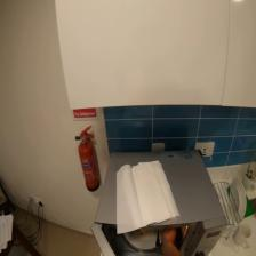

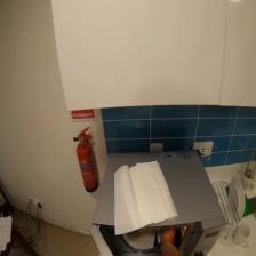

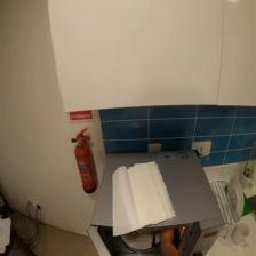

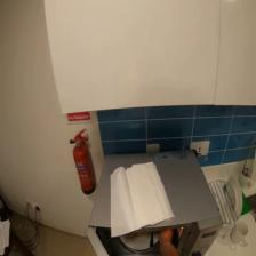

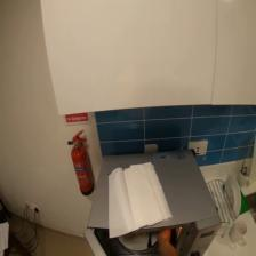

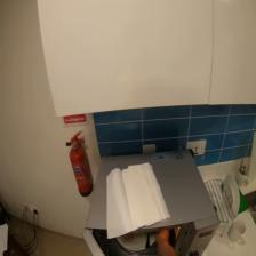

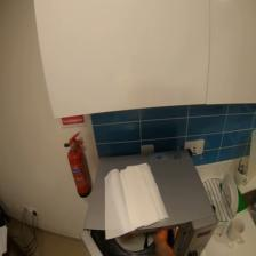

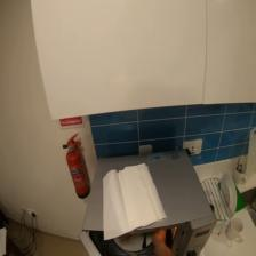

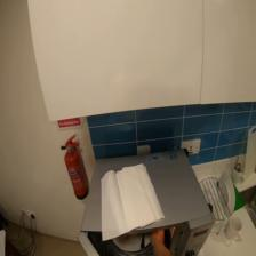

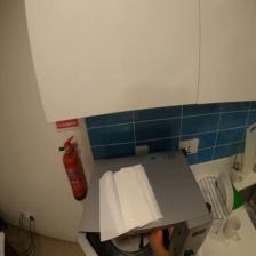

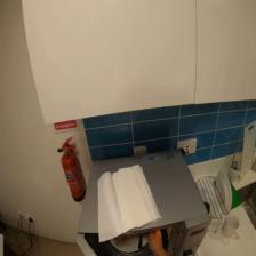

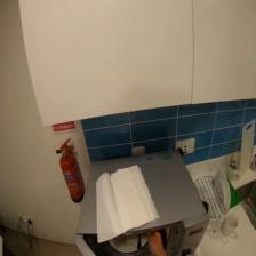

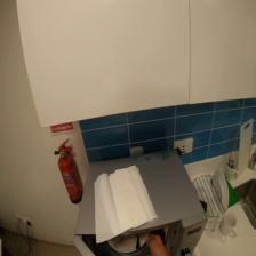

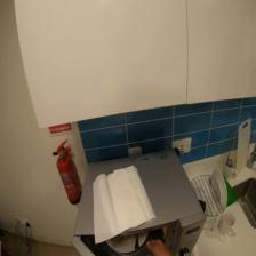

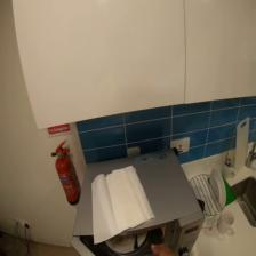

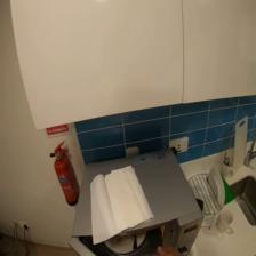

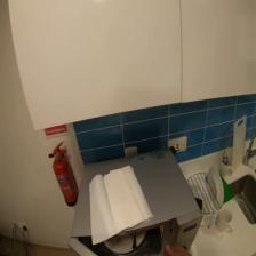

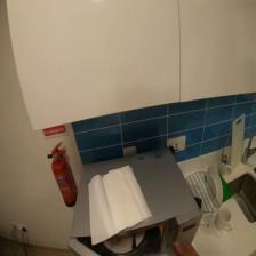

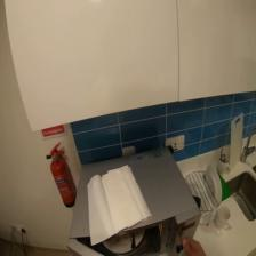

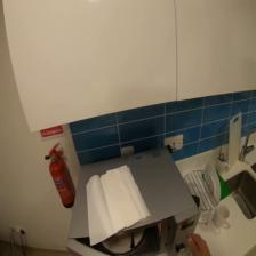

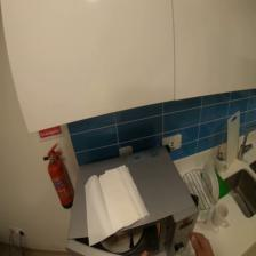

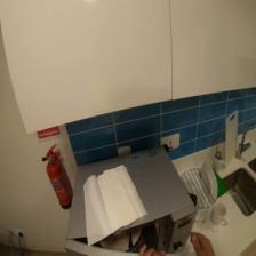

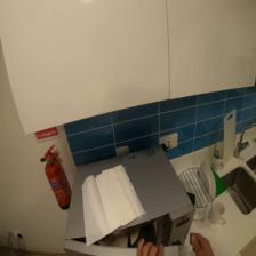

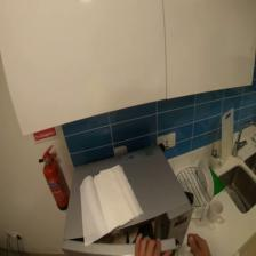

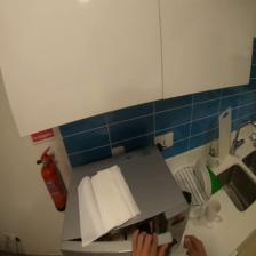

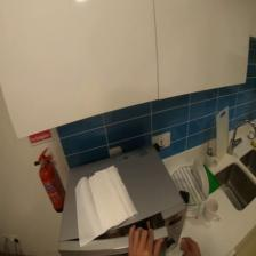

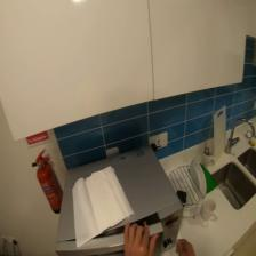

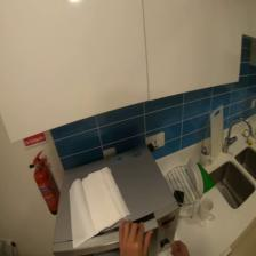

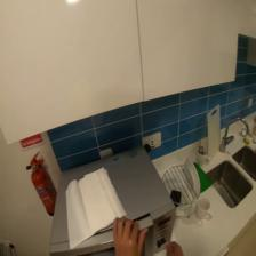

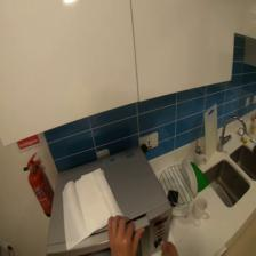

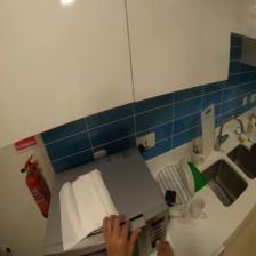

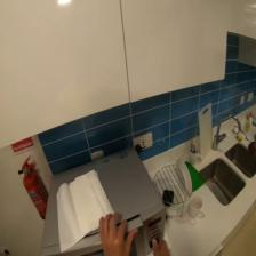

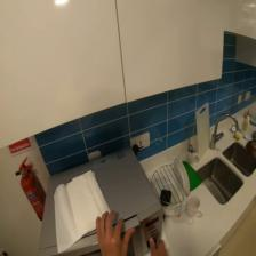

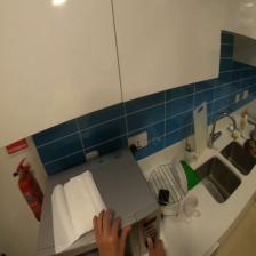

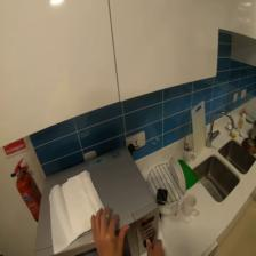

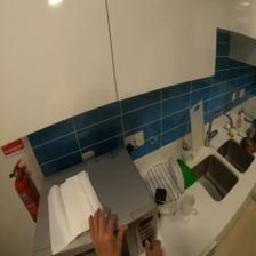

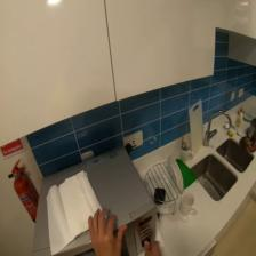

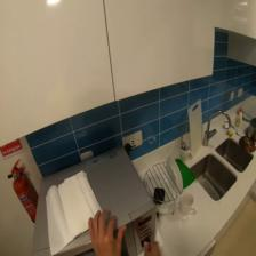

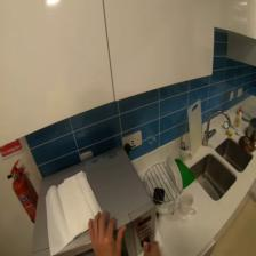

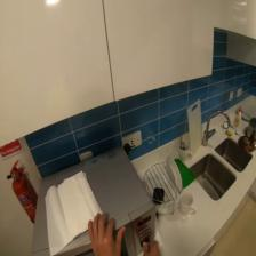

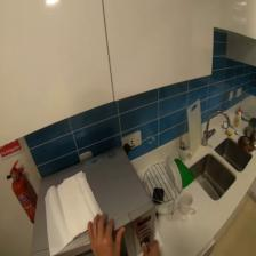

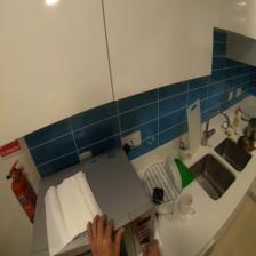

In [3]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb
import tensorflow as tf
import random

sth_sth_process = False
ego4d_preprocessing = True
narrations = False

if sth_sth_process:
    # manifest = json.load(open('/shared/group/ego4d/v1/annotations/moments_train.json'))
    # vidid2vid = {}
    # i = 0
    # for vid in manifest['videos']:
    #     vidid2vid[vid['video_uid']] = vid
    #     i += 1
    #     if i == 100:
    #         break

    data_path = "/home/ademi_adeniji/ego4dclips/" 
    vid = data_path + 'c0e4d122-e7a9-4ed7-ac53-691906a43116'
    for i in range(0, 1000, 10):
        image = torchvision.io.read_image(f"{vid}/{i}.jpg")
        show_images_ego4d(image, size=(256, 256))
elif ego4d_preprocessing:
    if narrations:
        vidpath = "/shared/ademi_adeniji/ego4d/videosresize224/"
        manifest_json = '/home/ademi_adeniji/ego4dstuff/narration.json'
        json = pd.read_json(manifest_json)
        uid = random.choice(json.keys())
        while json[uid]['narration_pass_1'] != json[uid]['narration_pass_1'] or len(json[uid]['narration_pass_1']['narrations']) == 0 or not os.path.exists(vidpath + uid):
            uid = random.choice(json.keys())
        narrations = json[uid]['narration_pass_1']['narrations']
        narration_idx = random.choice(range(len(narrations)))
        narration = narrations[narration_idx]
        vidpath = vidpath + uid
        start_frame = narration['timestamp_frame']
        try:
            next_narration = narrations[narration_idx+1]
            end_frame = next_narration['timestamp_frame']
        except:
            end_frame = start_frame + 10
        print(narration['narration_text'])
        print(vidpath)
        print(start_frame)
        print(end_frame)
        images = []
        for image in range(start_frame, end_frame, 1):
            load = tf.keras.preprocessing.image.load_img(
                          vidpath+f"/{image:07}.jpg",
                          grayscale=False,
                          color_mode='rgb',
                      )
            images.append(load)
        ims = tf.cast(tf.stack([tf.keras.preprocessing.image.img_to_array(x) for x in images], 0), tf.float32)
        for im in ims:
            show_images_ego4d(torch.from_numpy(im.numpy()).permute((2, 0, 1)), size=(256, 256))
    else:
        manifest_csv = '/shared/ademi_adeniji/ego4d/videosresize224/manifest.csv'
        csv = pd.read_csv(manifest_csv)
        labels = csv['label'].unique()
        label = 'use_the_microwave_/_warm_something_in_the_microwave'
#         label = 'clean_/_wipe_other_surface_or_object' # 
#         label = 'clean_/_wipe_kitchen_appliance' 
        vid_csv = csv[csv['label'] == label]
        vid_csv = vid_csv.sample(n=1).iloc[0]
        vidpath = vid_csv.vidpath
        print(vidpath)
        print(vid_csv.start_frame)
        print(vid_csv.end_frame)
        print(vid_csv.end_frame - vid_csv.start_frame)
        images = []
        for image in range(vid_csv.start_frame, vid_csv.end_frame, 1):
            load = tf.keras.preprocessing.image.load_img(
                          vidpath+f"/{image:07}.jpg",
                          grayscale=False,
                          color_mode='rgb',
                      )
            images.append(load)
        ims = tf.cast(tf.stack([tf.keras.preprocessing.image.img_to_array(x) for x in images], 0), tf.float32)
        for im in ims:
            show_images_ego4d(torch.from_numpy(im.numpy()).permute((2, 0, 1)), size=(256, 256))
else:
    raise ValueError("invalid processing type specified")

In [4]:
csv.head()

Unnamed: 0                              label  \
0           0      use_a_vacuum_cleaner_to_clean   
1           1  walk_down_stairs_/_walk_up_stairs   
2           2                      mop_the_floor   
3           3      use_a_vacuum_cleaner_to_clean   
4           4  walk_down_stairs_/_walk_up_stairs   

                                             vidpath  start_frame  end_frame  
0  /shared/ademi_adeniji/ego4d/videosresize224/7b...          179       6072  
1  /shared/ademi_adeniji/ego4d/videosresize224/7b...         6831       7109  
2  /shared/ademi_adeniji/ego4d/videosresize224/7b...        13157      14401  
3  /shared/ademi_adeniji/ego4d/videosresize224/7b...            1       5510  
4  /shared/ademi_adeniji/ego4d/videosresize224/7b...         6382       6686

In [76]:
epsilon = 1e-8
def r3m_neglang(start, end, lang, neg_lang):
    pos_rew = r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0] #.cpu().detach()
    neg_rew = 0
    for neg in neg_lang:
        neg_rew += r3m_scratch.module.get_reward(start_scratch, end_scratch, neg)[0]
    num = (epsilon + torch.exp(pos_rew))
    denom = epsilon + torch.exp(pos_rew) + torch.exp(neg_rew)
    final = num / denom
    return final.cpu().detach().item()

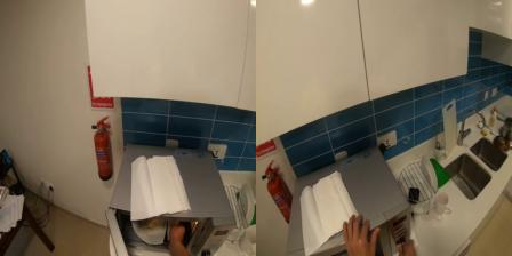

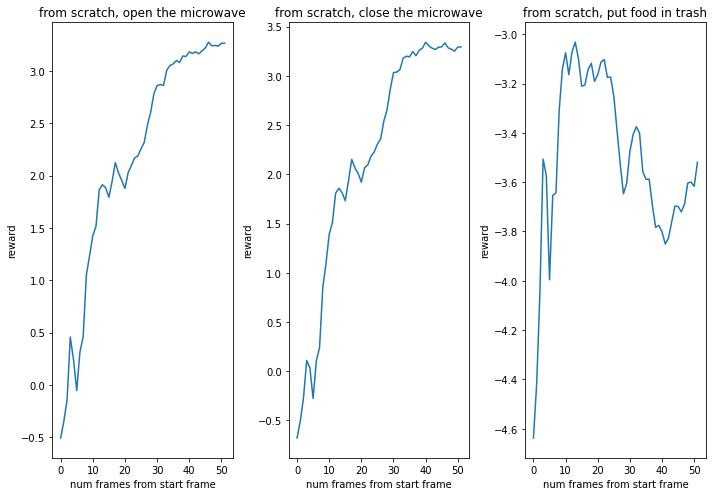

In [5]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

if ego4d_preprocessing:
    vid = vidpath
    vidlen = len(images)
else:
    vidlen = end_frame - start_frame
    
label = "open the microwave"
lang = np.array([label])
label_inv = "close the microwave"
label_alt = "put food in trash"
lang_inv = np.array([label_inv])
lang_alt = np.array([label_alt])
resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
if ego4d_preprocessing:
    start_image = torchvision.io.read_image(f"{vid}/{vid_csv.start_frame:07}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vid_csv.end_frame:07}.jpg")
else:
    start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
#     rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
#     rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].plot(rewards_scratch)
axs[0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set(xlabel="num frames from start frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set(xlabel="num frames from start frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()


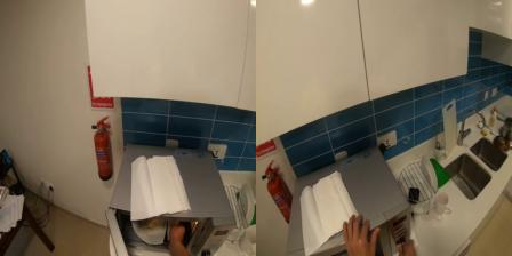

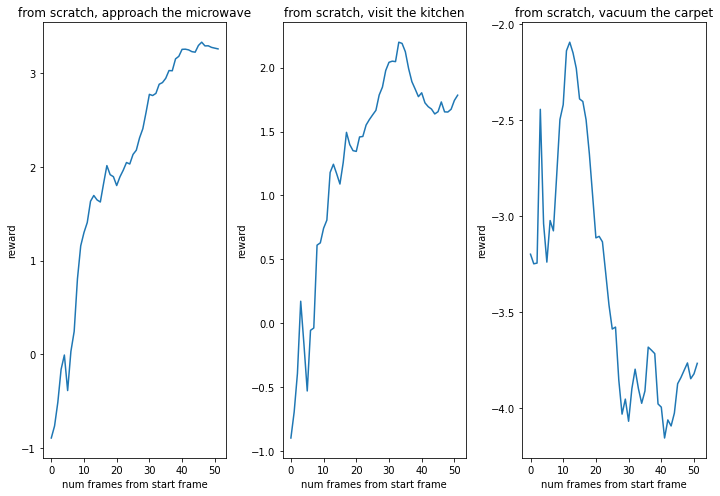

In [84]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

if ego4d_preprocessing:
    vid = vidpath
    vidlen = len(images)
else:
    vidlen = end_frame - start_frame
    
label = "approach the microwave"
lang = np.array([label])
label_inv = "visit the kitchen"
label_alt = "vacuum the carpet"
lang_inv = np.array([label_inv])
lang_alt = np.array([label_alt])
resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
if ego4d_preprocessing:
    start_image = torchvision.io.read_image(f"{vid}/{vid_csv.start_frame:07}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vid_csv.end_frame:07}.jpg")
else:
    start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
    rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].plot(rewards_scratch)
axs[0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set(xlabel="num frames from start frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set(xlabel="num frames from start frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()


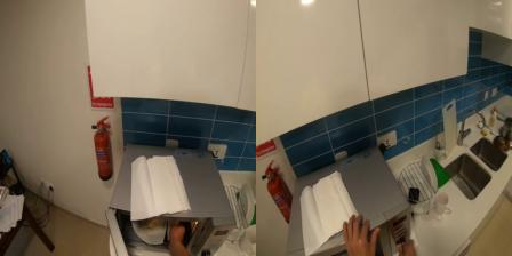

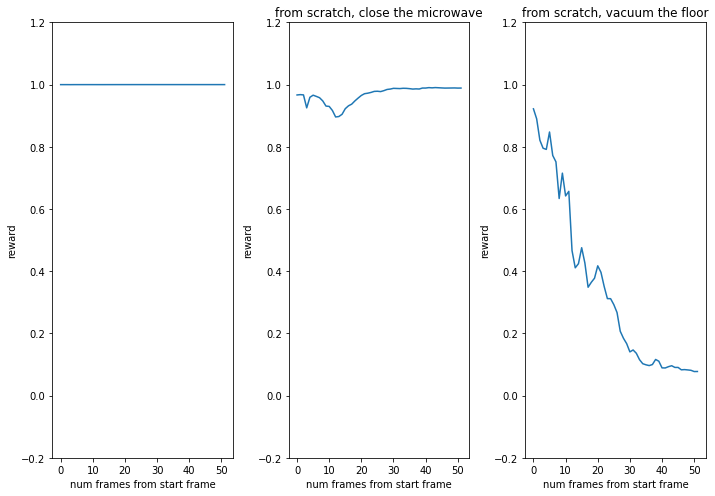

In [78]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

if ego4d_preprocessing:
    vid = vidpath
    vidlen = len(images)
else:
    vidlen = end_frame - start_frame
    
label = "open the microwave"
lang = np.array([label])
label_inv = "close the microwave"
label_alt = "vacuum the floor"# "put food in trash"
lang_inv = np.array([label_inv])
lang_alt = np.array([label_alt])
resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
if ego4d_preprocessing:
    start_image = torchvision.io.read_image(f"{vid}/{vid_csv.start_frame:07}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vid_csv.end_frame:07}.jpg")
else:
    start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_neglang(start_scratch, end_scratch, lang, ["grab the shampoo", "sweep the floor"]))
    rewards_scratch_inv.append(r3m_neglang(start_scratch, end_scratch, lang_inv, ["open the microwave", "sweep the floor"]))
    rewards_scratch_alt.append(r3m_neglang(start_scratch, end_scratch, lang_alt, ["open the microwave", "grab the shampoo"]))
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].set_ylim(-0.2, 1.2)
axs[0].plot(np.arange(len(rewards_scratch)), np.array(rewards_scratch))
axs[0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set_ylim(-0.2, 1.2)
axs[1].set(xlabel="num frames from start frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set_ylim(-0.2, 1.2)
axs[2].set(xlabel="num frames from start frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()


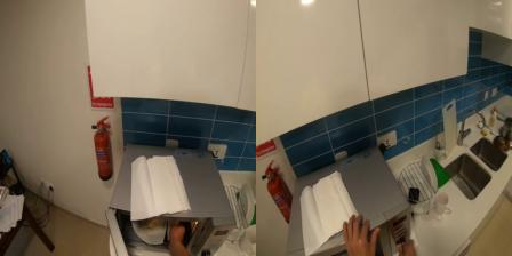

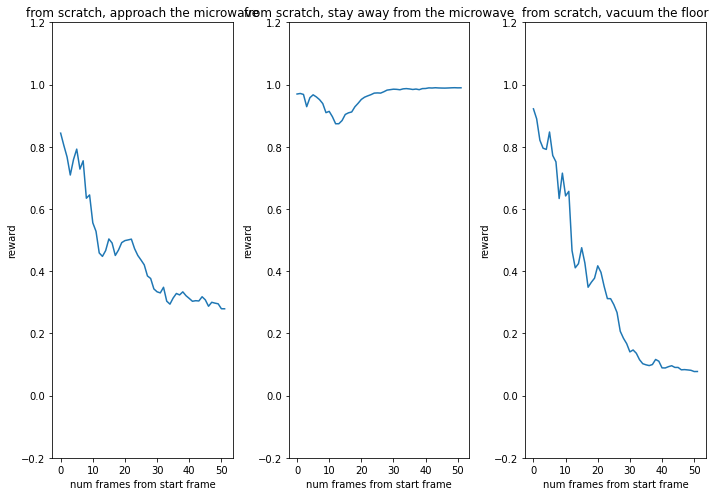

In [81]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

if ego4d_preprocessing:
    vid = vidpath
    vidlen = len(images)
else:
    vidlen = end_frame - start_frame
    
label = "approach the microwave"
lang = np.array([label])
label_inv = "stay away from the microwave"
label_alt = "vacuum the floor"# "put food in trash"
lang_inv = np.array([label_inv])
lang_alt = np.array([label_alt])
resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
if ego4d_preprocessing:
    start_image = torchvision.io.read_image(f"{vid}/{vid_csv.start_frame:07}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vid_csv.end_frame:07}.jpg")
else:
    start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_neglang(start_scratch, end_scratch, lang, ["leave the kitchen", "stay away from the microwave"]))
    rewards_scratch_inv.append(r3m_neglang(start_scratch, end_scratch, lang_inv, ["approach the microwave", "sweep the floor"]))
    rewards_scratch_alt.append(r3m_neglang(start_scratch, end_scratch, lang_alt, ["open the microwave", "grab the shampoo"]))
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].set_ylim(-0.2, 1.2)
axs[0].plot(np.arange(len(rewards_scratch)), np.array(rewards_scratch))
axs[0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set_ylim(-0.2, 1.2)
axs[1].set(xlabel="num frames from start frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set_ylim(-0.2, 1.2)
axs[2].set(xlabel="num frames from start frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()


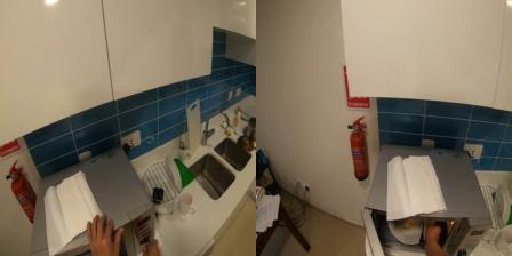

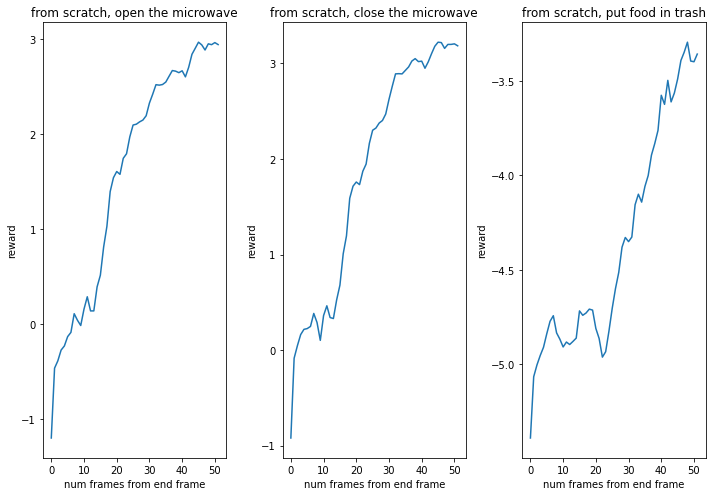

In [6]:
start = resize((end_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in reversed(range(vidlen)):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
    rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([end_image, start_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].plot(rewards_scratch)
axs[0].set(xlabel="num frames from end frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set(xlabel="num frames from end frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set(xlabel="num frames from end frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()


### CLIP

In [7]:
import transformers

In [8]:
clip_model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
tokenizer = transformers.CLIPTokenizer.from_pretrained(
            "openai/clip-vit-base-patch32"
        )
tokenizer.model_max_length = 53

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [9]:
tokens = tokenizer(["see the dog cat bird", "i like eating waffles and eggs"], padding="max_length")["input_ids"]
tokens = torch.tensor(tokens).cuda()
start_img = start.cuda().repeat(2, 1, 1, 1)
print(start_img.device, tokens.device)
print(tokens.shape, start_img.shape)
out = clip_model(tokens, start_img, return_loss=True)

cuda:0 cuda:0
torch.Size([2, 53]) torch.Size([2, 3, 224, 224])


In [10]:
print(out['loss'])
out['logits_per_image'][0], out['logits_per_text']

tensor(1.1561, device='cuda:0', grad_fn=<DivBackward0>)


(tensor([22.3984, 19.2437], device='cuda:0', grad_fn=<SelectBackward>),
 tensor([[22.3984, 22.3984],
         [19.2437, 19.2437]], device='cuda:0', grad_fn=<MulBackward0>))

In [21]:
# def clip_embedding(img):
#     hid = clip_model(start).last_hidden_state 
#     hid = hid.mean(1)
#     return hid
def clip_score_delta_cosine(img1, img2, tokens1, tokens2):
    img1 = img1.cuda()
    img2 = img2.cuda()
    if img1.shape[0] != tokens1.shape[0]:
        img1 = img1.repeat(tokens1.shape[0], 1, 1, 1)
    if img2.shape[0] != tokens2.shape[0]:
        img2 = img2.repeat(tokens2.shape[0], 1, 1, 1)
    img1_feats = clip_model.get_image_features(img1)
    img2_feats = clip_model.get_image_features(img2)
    text1_feats = clip_model.get_text_features(tokens1)
    text2_feats = clip_model.get_text_features(tokens2)
    
    img1_feats = img1_feats / img1_feats.norm(dim=-1, keepdim=True)
    img2_feats = img2_feats / img2_feats.norm(dim=-1, keepdim=True)
    text1_feats = text1_feats / text1_feats.norm(dim=-1, keepdim=True)
    text2_feats = text2_feats / text2_feats.norm(dim=-1, keepdim=True)
    return ((img2_feats-img1_feats)*(text2_feats-text1_feats)).sum(dim=1)

def clip_score_delta_l2(img1, img2, tokens1, tokens2):
    img1 = img1.cuda()
    img2 = img2.cuda()
    if img1.shape[0] != tokens1.shape[0]:
        img1 = img1.repeat(tokens1.shape[0], 1, 1, 1)
    if img2.shape[0] != tokens2.shape[0]:
        img2 = img2.repeat(tokens2.shape[0], 1, 1, 1)
    img1_feats = clip_model.get_image_features(img1)
    img2_feats = clip_model.get_image_features(img2)
    text1_feats = clip_model.get_text_features(tokens1)
    text2_feats = clip_model.get_text_features(tokens2)
    
    img1_feats = img1_feats / img1_feats.norm(dim=-1, keepdim=True)
    img2_feats = img2_feats / img2_feats.norm(dim=-1, keepdim=True)
    text1_feats = text1_feats / text1_feats.norm(dim=-1, keepdim=True)
    text2_feats = text2_feats / text2_feats.norm(dim=-1, keepdim=True)
    return ((img2_feats-img1_feats)-(text2_feats-text1_feats)).square().sum(dim=1)

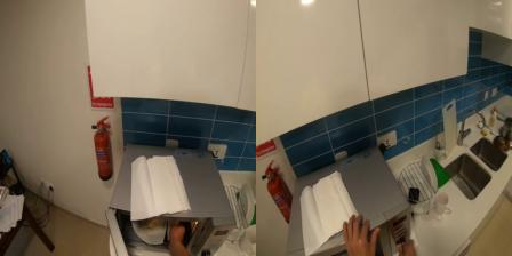

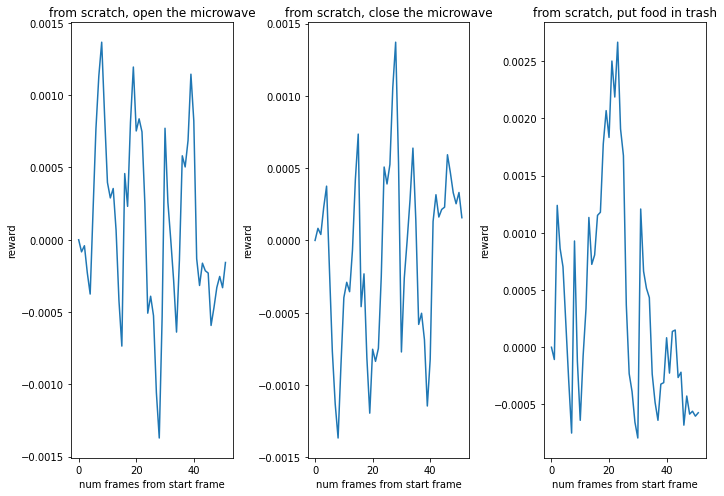

In [20]:
if ego4d_preprocessing:
    vid = vidpath
    vidlen = len(images)
else:
    vidlen = end_frame - start_frame
    
langs = ["open the microwave", "close the microwave", "put food in trash"]
lang_tokens = tokenizer(langs, padding="max_length")["input_ids"]
lang_tokens = torch.tensor(lang_tokens).cuda()

start_langs = ["close the microwave", "open the microwave", "take food out of trash"]
start_lang_tokens = tokenizer(start_langs, padding="max_length")["input_ids"]
start_lang_tokens = torch.tensor(start_lang_tokens).cuda()

resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
if ego4d_preprocessing:
    start_image = torchvision.io.read_image(f"{vid}/{vid_csv.start_frame:07}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vid_csv.end_frame:07}.jpg")
else:
    start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
# start_scratch = clip_embedding(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
#     scores = clip_score(end, lang_tokens)
    scores = clip_score_delta_cosine(start, end, start_lang_tokens, lang_tokens)
    rewards_scratch.append(scores[0].item())
    rewards_scratch_inv.append(scores[1].item())
    rewards_scratch_alt.append(scores[2].item())
#     end_scratch = clip_embedding(end.to('cuda:0'))
#     rewards_scratch.append(clip_embedding.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
#     rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
#     rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].plot(rewards_scratch)
axs[0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set(xlabel="num frames from start frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set(xlabel="num frames from start frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()


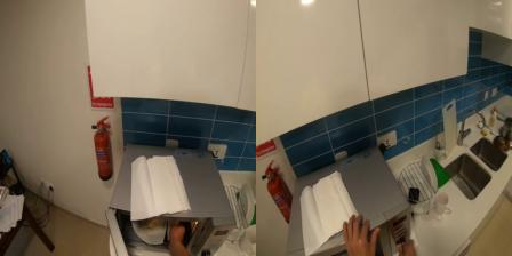

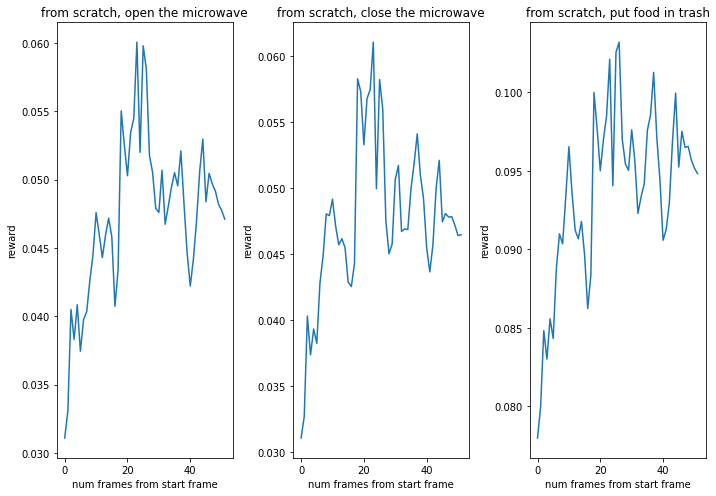

In [22]:
if ego4d_preprocessing:
    vid = vidpath
    vidlen = len(images)
else:
    vidlen = end_frame - start_frame
    
langs = ["open the microwave", "close the microwave", "put food in trash"]
lang_tokens = tokenizer(langs, padding="max_length")["input_ids"]
lang_tokens = torch.tensor(lang_tokens).cuda()

start_langs = ["close the microwave", "open the microwave", "take food out of trash"]
start_lang_tokens = tokenizer(start_langs, padding="max_length")["input_ids"]
start_lang_tokens = torch.tensor(start_lang_tokens).cuda()

resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
if ego4d_preprocessing:
    start_image = torchvision.io.read_image(f"{vid}/{vid_csv.start_frame:07}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vid_csv.end_frame:07}.jpg")
else:
    start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
# start_scratch = clip_embedding(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
#     scores = clip_score(end, lang_tokens)
    scores = clip_score_delta_l2(start, end, start_lang_tokens, lang_tokens)
    rewards_scratch.append(scores[0].item())
    rewards_scratch_inv.append(scores[1].item())
    rewards_scratch_alt.append(scores[2].item())
#     end_scratch = clip_embedding(end.to('cuda:0'))
#     rewards_scratch.append(clip_embedding.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
#     rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
#     rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].plot(rewards_scratch)
axs[0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set(xlabel="num frames from start frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set(xlabel="num frames from start frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()
